In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import os
import time

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.model_selection as model_selection

import tensorflow as tf
from tensorflow import keras

import h5py

In [2]:
# Set your own project id here
# PROJECT_ID = 'your-google-cloud-project'
# from google.cloud import storage
# storage_client = storage.Client(project=PROJECT_ID)

In [3]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]

In [4]:
# def decode(serialized_example):
#     feats = tf.io.parse_single_example(serialized_example, features={'x1': tf.io.FixedLenFeature([], tf.string),
#                                                                      'x2': tf.io.FixedLenFeature([], tf.string),
#                                                                      'x3': tf.io.FixedLenFeature([], tf.string),
#                                                                      'y': tf.io.FixedLenFeature([], tf.string)})

#     x1 = tf.io.decode_raw(feats['x1'], tf.float64)
#     x1 = tf.reshape(x1, [32,37,32,53])

#     x2 = tf.io.decode_raw(feats['x2'], tf.float64)
#     x2.set_shape((1378))

#     x3 = tf.io.decode_raw(feats['x3'], tf.float64)
#     x3.set_shape((26))

#     y = tf.io.decode_raw(feats['y'], tf.float64)
#     y.set_shape((5))

#     X = (x1, x2, x3)
#     return X, y

In [5]:
# def get_dataset(tfr_data, batch_size):
#     ignore_order = tf.data.Options()
#     ignore_order.experimental_deterministic = False

#     ds = tf.data.TFRecordDataset(tfr_data, compression_type="GZIP")
#     ds = ds.with_options(ignore_order)
#     ds = ds.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# #     ds = ds.with_options(ignore_order)
# #     ds = ds.shuffle(buffer_size=4000, seed=30, reshuffle_each_iteration=True)
#     ds = ds.batch(batch_size, drop_remainder=False)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

In [6]:
# batch_size = 32

# tfr_train = tf.io.gfile.glob("00_Data/tfr_train/*.tfrecord")
# tfr_val = tf.io.gfile.glob("00_Data/tfr_val/*.tfrecord")
# tfr_test = tf.io.gfile.glob("00_Data/tfr_test/*.tfrecord")

# # tfr_train = tf.io.gfile.glob("gs://trends_2020_tfr/train/*.tfrecord")
# # tfr_val = tf.io.gfile.glob("gs://trends_2020_tfr/val/*.tfrecord")
# # tfr_test = tf.io.gfile.glob("gs://trends_2020_tfr/test/*.tfrecord")

# ds_train = get_dataset(tfr_train, batch_size)
# ds_val = get_dataset(tfr_val, batch_size)
# ds_test = get_dataset(tfr_test, batch_size)

In [7]:
data = pd.read_csv('00_Data/train_scores_full.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10007,38.617381,49.197021,65.674285,40.151376,34.096421
4,10008,35.326582,15.769168,65.782269,44.643805,50.448485
...,...,...,...,...,...,...
5872,21654,53.103634,50.951656,62.168022,49.389400,53.020847
5873,21665,38.246437,48.018227,59.522285,45.697098,53.208160
5874,21674,69.414169,58.593918,60.298779,49.865669,47.863167
5875,21693,62.009209,54.272484,60.474388,52.325031,52.989803


In [8]:
def get_inputs(idx, labels):
    # FNC inputs
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    # Loading inputs
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)
    
    #MRI inputs
    patient_SM = h5py.File('00_Data/fMRI_train/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
#     patient_SM = mat.transpose([1,2,3,0])

#     print('patient: {idx}')
    
    k = 1
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
#         print(len(arr_regions))
        # padding MRI map
        if k > 1:
            map_shape = sample_map.shape
            shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                         (map_shape[1]//k + 1)*k - map_shape[1],
                         (map_shape[2]//k + 1)*k - map_shape[2])

            npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                    (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                    (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

            sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

            sx = sample_map_padded.shape[0] / k
            sy = sample_map_padded.shape[1] / k
            sz = sample_map_padded.shape[2] / k
            for kz in range(k):
                for ky in range(k):
                    for kx in range(k):
                        ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                     int(ky*sy): int(ky*sy + sy - 1), 
                                                     int(kz*sz): int(kz*sz + sz - 1)]
                        #padding i-th region by 3 pixels
                        ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                        arr_regions.append(ki_region_padded)
        else:
            map_padded = np.pad(sample_map, pad_width=ki_padding, mode='constant', constant_values=0)
            arr_regions.append(map_padded)
#             print(map_padded.shape)
    X_mri = np.stack(arr_regions, axis=3)
    
    X = (X_mri, X_fnc, X_loading)
    return X, labels

In [9]:
def new_py_function(func, inp, Tout, name=None):
    
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,
                                                     expand_composites=True)
        out = func(*reconstructed_inp)
        return tf.nest.flatten(out, expand_composites=True)
    
    flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
    flat_out = tf.py_function(func=wrapped_func, 
                              inp=tf.nest.flatten(inp, expand_composites=True),
                              Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
                              name=name)
    spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, expand_composites=True)
    out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
    return out

def _dtype_to_tensor_spec(v):
    return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
    return v.dtype if isinstance(v, tf.TensorSpec) else v

In [10]:
def get_dataset(data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
                                               data[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']].values))
    data = data.shuffle(buffer_size=4000, seed=30, reshuffle_each_iteration=True)
    
    data = data.map(lambda idx, lbl:new_py_function(get_inputs, inp=(idx, lbl), 
                                                    Tout=((tf.TensorSpec(shape=(None, 58, 69, 59, 53), dtype=tf.dtypes.float64, name='input_mri'),
                                                           tf.TensorSpec(shape=(None, 1378), dtype=tf.dtypes.float64, name='input_fnc'), 
                                                           tf.TensorSpec(shape=(None, 26), dtype=tf.dtypes.float64, name='input_loading')), 
                                                          tf.TensorSpec(shape=(None, 5), dtype=tf.dtypes.float64, name='labels')), name=None), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=True)
    data = data.batch(batch_size, drop_remainder=False)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [11]:
train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=True, random_state=30)
train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [12]:
batch_size = 8

ds_train = get_dataset(train, batch_size)
ds_val = get_dataset(val, batch_size)
ds_test = get_dataset(test, batch_size)

In [13]:
# for i in ds_train.take(1):
#     pass

In [14]:
INPUT_SHAPE_mri = (58, 69, 59, 53)

In [15]:
INPUT_SHAPE_fnc = (1378,)

In [16]:
INPUT_SHAPE_loading = (26,)

In [17]:
def create_model(INPUT_SHAPE_mri, INPUT_SHAPE_fnc, INPUT_SHAPE_loading):
    #============================================================================
    # CNN for MRI images processing
    #============================================================================
    inputs_mri = keras.layers.Input(shape=INPUT_SHAPE_mri, name='inpupt_mri')

    # convolution block #1
    block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(inputs_mri)
    block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_1)
    block_1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_1)

    # convolution block #2
    block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_1)
    block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_2)
    block_2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_2)

    # convolution block #3
    block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_2)
    block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_3)
    block_3 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_3)

    # convolution block #4
    block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_3)
    block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_4)
    block_4 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_4)

    flatten = keras.layers.Flatten(data_format='channels_last')(block_4)

    # hidden layer
    x = keras.layers.Dense(256,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(flatten)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(x)

    # output
    x = keras.Model(inputs=inputs_mri, outputs=x, name='model_mri')

    #============================================================================
    # MLP for FNC correlation features processing
    #============================================================================
    inputs_fnc = keras.layers.Input(shape=INPUT_SHAPE_fnc, name='input_fnc')

    y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(inputs_fnc)
    y = keras.layers.Dense(2048,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

    y1 = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y1)
    y1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(y1)

    y2 = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y2)
    y2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(y2)

    y = keras.layers.concatenate([y1, y2])

    y = keras.layers.Dense(256,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)
    y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(y)

    # output
    y = keras.Model(inputs=inputs_fnc, outputs=y, name='model_fnc')

    #============================================================================
    # MLP for sMRI SBM loadings processing
    #============================================================================
    inputs_loading = keras.layers.Input(shape=INPUT_SHAPE_loading, name='input_load')

    z = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(inputs_loading)

    z = keras.layers.Dense(256,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

    z1 = keras.layers.Dense(128,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z1)
    z1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(z1)

    z2 = keras.layers.Dense(128,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z2)
    z2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(z2)

    z = keras.layers.concatenate([z1, z2])

    z = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)
    z = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(z)

    # output
    z = keras.Model(inputs=inputs_loading, outputs=z, name='model_loading')

    
    concat = keras.layers.concatenate([x.output, y.output, z.output])


    concat1 = keras.layers.Dense(256, 
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(concat)
    concat1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat1)
    concat1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(concat1)
    
    concat2 = keras.layers.Dense(256, 
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(concat)
    concat2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat2)
    concat2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(concat2)
    
    concat = keras.layers.concatenate([concat1, concat2])

    concat = keras.layers.Dense(512, 
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(concat)
    concat = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat)

    outputs = keras.layers.Dense(5, activation='linear')(concat)

    model = keras.Model(inputs=[x.input, y.input, z.input], outputs=outputs, name='model_combined')

    optim = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

    METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
               keras.metrics.MeanSquaredError(name='mse')]

    model.compile(loss='mae', metrics=METRICS, optimizer=optim)
    return model

In [18]:
model = create_model(INPUT_SHAPE_mri, INPUT_SHAPE_fnc, INPUT_SHAPE_loading)

In [19]:
model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpupt_mri (InputLayer)         [(None, 58, 69, 59,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 58, 69, 59, 6 91648       inpupt_mri[0][0]                 
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 58, 69, 59, 6 15111552    conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 58, 69, 59, 6 110656      p_re_lu[0][0]                    
_____________________________________________________________________________________

In [22]:
# from keras.utils import plot_model
# plot_model(model, show_shapes=True)

In [32]:
checkpoint_dir = './99_Training_checkpoints/mri-fnc-loading'

In [33]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [22]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                               min_delta=0.001, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=True)]

In [23]:
checkpoint_prefix = os.path.join('./99_Training_checkpoints/mri-fnc-loading', "ckpt_{epoch}")

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/mri-fnc-loading'),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=5, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [24]:
with tf.device('/GPU:0'):
# with tf.device('/CPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     callbacks=callbacks,
                     epochs=400,
                     verbose=1)

Epoch 1/400
470/470 [==============================] - 1969s 4s/step - loss: 52.7655 - rmse: 54.9866 - mse: 3023.5239 - val_loss: 51.0152 - val_rmse: 53.2143 - val_mse: 2831.7598
Epoch 2/400
470/470 [==============================] - 1993s 4s/step - loss: 50.1769 - rmse: 52.5114 - mse: 2757.4429 - val_loss: 48.2894 - val_rmse: 50.6562 - val_mse: 2566.0464
Epoch 3/400
470/470 [==============================] - 1925s 4s/step - loss: 46.9892 - rmse: 49.4688 - mse: 2447.1675 - val_loss: 44.8396 - val_rmse: 47.3759 - val_mse: 2244.4758
Epoch 4/400
470/470 [==============================] - 1924s 4s/step - loss: 43.3097 - rmse: 45.9785 - mse: 2114.0271 - val_loss: 40.9185 - val_rmse: 43.6553 - val_mse: 1905.7866
Epoch 5/400
470/470 [==============================] - 1928s 4s/step - loss: 39.2130 - rmse: 42.1169 - mse: 1773.8353 - val_loss: 36.6465 - val_rmse: 39.6396 - val_mse: 1571.2964
Epoch 6/400
470/470 [==============================] - 1927s 4s/step - loss: 34.7881 - rmse: 37.9662 - ms

ResourceExhaustedError:  OOM when allocating tensor with shape[8,64,58,69,59] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_combined/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-24-556e1565734a>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_9743]

Function call stack:
train_function


In [34]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

147/147 [==============================] - 432s 3s/step - loss: 8.0011 - rmse: 10.5004 - mse: 110.2587TA: 5:53 - loss: 8.1505 - rmse: 10.7224 - mse: 114.970 - ETA: 5:54 - loss: 8.2938 - rmse: 10.828 - ETA: 5:40 - loss: 8.2050 - rmse: 10.6929 - mse: 114.3 - ETA: 5:24 - loss: 8.2535 - rmse: 10.7792 - mse - ETA: 4:56 - loss: 8.1050  - ETA: 3:26 - loss: 7.8890 - rmse: 10.3689 - mse: 107.51 - ETA: 3:19 - loss: 7.9023 - rmse: 1 - ETA: 2:16 -  - ETA: 32s - loss: 7.9700 - rmse: 10.4486 - mse: 109.17 - ETA: 29s - loss: 7.9624 - rmse: 10.44


NameError: name 'hist' is not defined

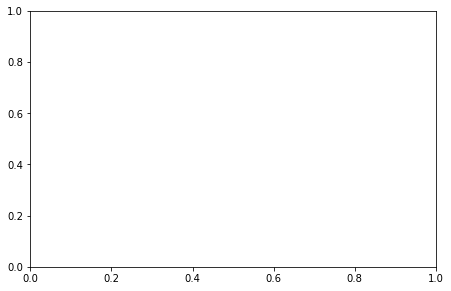

In [35]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [38]:
def get_inputs_subm(idx):
    # FNC inputs
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    # Loading inputs
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)
    
    #MRI inputs
    patient_SM = h5py.File('00_Data/fMRI_test/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
#     patient_SM = mat.transpose([1,2,3,0])

#     print('patient: {idx}')
    
    k = 1
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
#         print(len(arr_regions))
        # padding MRI map
        if k > 1:
            map_shape = sample_map.shape
            shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                         (map_shape[1]//k + 1)*k - map_shape[1],
                         (map_shape[2]//k + 1)*k - map_shape[2])

            npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                    (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                    (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

            sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

            sx = sample_map_padded.shape[0] / k
            sy = sample_map_padded.shape[1] / k
            sz = sample_map_padded.shape[2] / k
            for kz in range(k):
                for ky in range(k):
                    for kx in range(k):
                        ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                     int(ky*sy): int(ky*sy + sy - 1), 
                                                     int(kz*sz): int(kz*sz + sz - 1)]
                        #padding i-th region by 3 pixels
                        ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                        arr_regions.append(ki_region_padded)
        else:
            map_padded = np.pad(sample_map, pad_width=ki_padding, mode='constant', constant_values=0)
            arr_regions.append(map_padded)
#             print(map_padded.shape)
    X_mri = np.stack(arr_regions, axis=3)
    
#     X = (X_mri, X_fnc, X_loading)
    return X_mri, X_fnc, X_loading

In [39]:
y_preds = []
for i in TEST_IDS:
    X_mri, X_fnc, X_loading = get_inputs_subm(i)
    X_mri = X_mri.reshape(1,58, 69, 59, 53)
    X_fnc = X_fnc.reshape(1,1378)
    X_loading = X_loading.reshape(1,26)
    preds = model.predict([X_mri, X_fnc, X_loading], batch_size=1)
    y_preds.append(preds)

In [40]:
len(y_preds)

5877

In [41]:
y_preds = np.array(y_preds).flatten()

In [42]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [43]:
df_submission.to_csv('submission_mri-fnc-load_mae_08.csv', index=False)